<a href="https://colab.research.google.com/github/Ben93kie/TrackAndTrace/blob/main/DataExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Track and Trace - Praktikum im Bereich Data Science - Case Study**

---



# 1 Prerequisites, Data Loading and Preprocessing

Load required libraries

In [1]:
!pip install gmaps
!pip install feature-engine
import pandas as pd
import os
import gmaps
from google.colab import output
from datetime import datetime
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor
from feature_engine.creation import CyclicalFeatures
from sklearn.preprocessing import StandardScaler
from numpy import mean
from numpy import std
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
output.enable_custom_widget_manager()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 3.6 MB/s 
     |████████████████████████████████| 1.6 MB 40.8 MB/s 
  Created wheel for gmaps: filename=gmaps-0.9.0-py2.py3-none-any.whl size=2076111 sha256=3d81bd9d00ac84a47b11f116e97ce41d3035f51c81a9b832812a557e77564f59
  Stored in directory: /root/.cache/pip/wheels/3d/1c/cb/c46f4199210e632b28d78d05a00bfdccbf6dfcd3f5b051d6bf
Successfully built gmaps
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 4.0 MB/s 


Provide csv data paths

In [2]:
track_data_path = 'data.csv'
event_locations_path = 'event_locations.csv'

Load csv data in Pandas dataframes

In [3]:
track_data = pd.read_csv(track_data_path,delimiter=';') 
track_data2 = pd.read_csv(track_data_path,delimiter=';') 
event_locations = pd.read_csv(event_locations_path,delimiter=';')
event_locations = event_locations.set_index('EventLocation')

Have a first glance at the data points

In [4]:
track_data.head(10)

,ContainerNumber,ShipmentNumber,PoCreationDate,Material,ShipmentQuantity,Controller,EventName,EventTime,EventMessageTime,EventLocation,VesselName,PortofDischarge,Time2Arrival
0,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Loading Ship,07.04.18 13:58,08.04.18 03:19,urn:jaif:id:loc:26LNLRTM,NYK ROMULUS,NaN,125.0
1,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Departure Ship,07.04.18 19:05,09.04.18 16:29,urn:jaif:id:loc:26LNLRTM,NYK ROMULUS,NaN,125.0
2,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Unloading Ship,21.04.18 06:19,21.04.18 11:59,urn:jaif:id:loc:26LUSCHS,NYK ROMULUS,NaN,111.0
3,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Departure Truck,21.04.18 11:42,21.04.18 13:29,urn:jaif:id:loc:26LUSCHS,NYK ROMULUS,NaN,111.0
4,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Arrival Truck,08.05.18 18:12,23.05.18 22:04,urn:jaif:id:loc:26LUSCHS,NYK ROMULUS,NaN,94.0
5,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Arrival Truck,08.05.18 18:12,23.05.18 17:32,urn:jaif:id:loc:26LUSCHS,NYK ROMULUS,NaN,94.0
6,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Loading Truck,16.07.18 14:15,16.07.18 16:47,urn:jaif:id:loc:26LDESPE,NYK ROMULUS,NaN,25.0
7,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Arrival Truck,24.07.18 02:03,24.07.18 05:11,urn:jaif:id:loc:26LBEANR,NYK ROMULUS,NaN,17.0
8,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Arrival Ship,02.08.18 21:54,03.08.18 01:03,urn:jaif:id:loc:26LUSSAV,NYK ROMULUS,NaN,7.0
9,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Registration Yard,10.08.18 16:18,10.08.18 23:18,urn:jaif:id:loc:25LUN498999044W0138,NYK ROMULUS,NaN,0.0


Explore the locations

In [5]:
event_locations

,Bezeichnung
EventLocation,
urn:jaif:id:loc:26LNLRTM,Hafen Rotterdam
urn:jaif:id:loc:26LUSCHS,Hafen Charleston
urn:jaif:id:loc:26LDESPE,Consolidation Center Speyer
urn:jaif:id:loc:26LBEANR,Hafen Antwerpen
urn:jaif:id:loc:26LUSSAV,Bahnterminal Savannah
urn:jaif:id:loc:25LUN498999044W0138,Werk Tuscaloosa
urn:jaif:id:loc:26LDEBRV,Hafen Bremerhaven
urn:jaif:id:loc:26LDEHAM,Hafen Hamburg
urn:jaif:id:loc:26LMXATM,Hafen Altamira


Replace EventLocation with their human-readable name and shorten some features for readability

In [6]:
event_loc_to_name=event_locations.to_dict()
event_loc_to_name = event_loc_to_name['Bezeichnung']
event_loc_to_name[float('NaN')]=float('NaN')
event_loc_to_name['*Multiple*']='*Multiple*'
track_data.replace({"EventLocation" : event_loc_to_name, "PortofDischarge" : event_loc_to_name}, inplace=True)
track_data = track_data.rename(columns={'ShipmentQuantity' : 'Quant'})
track_data = track_data.rename(columns={'ContainerNumber' : 'Container'})
track_data = track_data.rename(columns={'Time2Arrival' : 'time'})

Take a deeper look

In [7]:
track_data.head(20)

,Container,ShipmentNumber,PoCreationDate,Material,Quant,Controller,EventName,EventTime,EventMessageTime,EventLocation,VesselName,PortofDischarge,time
0,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Loading Ship,07.04.18 13:58,08.04.18 03:19,Hafen Rotterdam,NYK ROMULUS,NaN,125.0
1,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Departure Ship,07.04.18 19:05,09.04.18 16:29,Hafen Rotterdam,NYK ROMULUS,NaN,125.0
2,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Unloading Ship,21.04.18 06:19,21.04.18 11:59,Hafen Charleston,NYK ROMULUS,NaN,111.0
3,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Departure Truck,21.04.18 11:42,21.04.18 13:29,Hafen Charleston,NYK ROMULUS,NaN,111.0
4,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Arrival Truck,08.05.18 18:12,23.05.18 22:04,Hafen Charleston,NYK ROMULUS,NaN,94.0
5,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Arrival Truck,08.05.18 18:12,23.05.18 17:32,Hafen Charleston,NYK ROMULUS,NaN,94.0
6,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Loading Truck,16.07.18 14:15,16.07.18 16:47,Consolidation Center Speyer,NYK ROMULUS,NaN,25.0
7,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Arrival Truck,24.07.18 02:03,24.07.18 05:11,Hafen Antwerpen,NYK ROMULUS,NaN,17.0
8,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Arrival Ship,02.08.18 21:54,03.08.18 01:03,Bahnterminal Savannah,NYK ROMULUS,NaN,7.0
9,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,T15,Registration Yard,10.08.18 16:18,10.08.18 23:18,Werk Tuscaloosa,NYK ROMULUS,NaN,0.0


Look at individual features and their instances

In [8]:
print('Event Names:\n', track_data['EventName'].unique())
print('Materials:\n', track_data['Material'].unique())
print('Shipment Quantities:\n', track_data['Quant'].unique())
print('Controllers:\n', track_data['Controller'].unique())
print('Vessel Names:\n', track_data['VesselName'].unique())
print('Event Locations:\n', track_data['EventLocation'].unique())
print('Ports of Discharge:\n', track_data['PortofDischarge'].unique())
print('Arrival Times:\n', track_data['time'].unique())

Event Names:
 ['Loading Ship' 'Departure Ship' 'Unloading Ship' 'Departure Truck'
 'Arrival Truck' 'Loading Truck' 'Arrival Ship' 'Registration Yard'
 'Goods Receipt Dock' 'New Scheduling' 'Container Closed']
Materials:
 ['A2760101414' 'A2760101614' 'A1662707202' 'A1662708602' 'A1662708702'
 'A6540107406' 'A2560107300' 'A2132704801' 'A2760106714' 'A2572700000']
Shipment Quantities:
 [ 72.  42.  24.  21.   6.  45.  33.  27. 144. 138. 150. 126.  12.  66.
 120.  15. 102.  36. 108.  30.  78.  54.  90.  39.   9.  60. 114.  96.
  48. 132.  18.   3.  69.  51.  84.  57.  47.  63. 156.  68. 162.  nan
 106. 122.  52.   2.  13.  53. 129. 135.  59.   5.]
Controllers:
 ['T15']
Vessel Names:
 ['NYK ROMULUS' 'CHARLESTON EXPRESS' 'YORKTOWN EXPRESS' 'MOL EMISSARY'
 'NYK DAEDALUS' 'PHILADELPHIA EXPRESS' 'SHANGHAI TRADER' 'MAINE TRADER'
 'ST LOUIS EXPRESS' 'MUNICH MAERSK' 'VECCHIO BRIDGE' 'WASHINGTON EXPRESS'
 'NYK RIGEL' 'NYK METEOR' 'EASLINE DALIAN' 'MONACO MAERSK' 'YM UNITY'
 'MOL EMPIRE' 'VENICE BRID

correct urn:jaif:id:loc:25LUN498999044W013 <- missing 8 probably

In [9]:
track_data.loc[track_data['EventLocation'] == 'urn:jaif:id:loc:25LUN498999044W013', 'EventLocation'] = 'Werk Tuscaloosa' 

Remove column "Controller" as it does not convey any information

In [10]:
track_data.drop(["Controller"], axis=1, inplace=True)

Further insights:


*   We have quite a number of NaN values
*   Start point sometimes/always missing?
*   (Almost) Duplicate data points? -> Coming from multiple packacges in same shipment?
*   Do not know the time zone -> Assume everything is GMT+2
*   A "data point" can also be seen as a time series here -> Look at rows with same shipment number 




Some helper functions to visualize shipments

In [11]:
def get_single_shipment(ShipmentNumber):
  return track_data[track_data['ShipmentNumber'] == ShipmentNumber]

def get_random_shipment_number():
  return int(track_data.sample()['ShipmentNumber'])

def convert_to_strptime(time_series):
  return pd.to_datetime(time_series, format='%d.%m.%y %H:%M')

def sort_by_date(df,feature):
  return df.sort_values(by=[feature], key=convert_to_strptime)

In [12]:
len(track_data)

35306

Delete rows with time=0 bc of lack of usefulness for prediction

In [13]:
track_data.drop(track_data.loc[track_data['time']==0].index, inplace=True)

Delete "missing"(?) entries in data

In [14]:
track_data.replace('###############################################################################################################################################################################################################################################################',float('NaN'),inplace=True)

In [15]:
len(track_data.loc[track_data['EventLocation'].isna()])

473

# 1.1 Dealing with NaNs

**EventLocation:**

In [16]:
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'MOL EMPIRE'), 'EventLocation'] = 'Hafen Bremerhaven'
track_data.iloc[10570:10580]

,Container,ShipmentNumber,PoCreationDate,Material,Quant,EventName,EventTime,EventMessageTime,EventLocation,VesselName,PortofDischarge,time
12430,TEMU7716965,5237336,14.08.18 00:00,A1662708602,144.0,Unloading Ship,26.09.18 07:09,26.09.18 09:14,Hafen Charleston,SHANGHAI TRADER,NaN,123.0
12431,TEMU7716965,5237336,14.08.18 00:00,A1662708602,144.0,Departure Truck,26.09.18 16:07,26.09.18 18:38,Hafen Charleston,SHANGHAI TRADER,NaN,123.0
12432,TEMU7716965,5237336,14.08.18 00:00,A1662708602,144.0,Arrival Truck,25.11.18 10:03,25.11.18 21:00,Hafen Bremerhaven,SHANGHAI TRADER,NaN,63.0
12433,TEMU7716965,5237336,14.08.18 00:00,A1662708602,144.0,Departure Ship,11.12.18 21:48,11.12.18 23:59,Hafen Bremerhaven,SHANGHAI TRADER,NaN,47.0
12434,TEMU7716965,5237336,14.08.18 00:00,A1662708602,144.0,Departure Ship,11.12.18 21:48,11.12.18 23:59,NaN,SHANGHAI TRADER,NaN,47.0
12435,TEMU7716965,5237336,14.08.18 00:00,A1662708602,144.0,New Scheduling,22.12.18 00:30,06.12.18 12:15,Hafen Charleston,SHANGHAI TRADER,NaN,37.0
12436,TEMU7716965,5237336,14.08.18 00:00,A1662708602,144.0,New Scheduling,23.12.18 17:00,12.12.18 17:05,Hafen Charleston,SHANGHAI TRADER,NaN,35.0
12437,TEMU7716965,5237336,14.08.18 00:00,A1662708602,144.0,New Scheduling,26.12.18 11:00,19.12.18 01:34,Hafen Charleston,SHANGHAI TRADER,NaN,32.0
12438,TEMU7716965,5237336,14.08.18 00:00,A1662708602,144.0,New Scheduling,27.12.18 00:00,24.12.18 19:03,Hafen Charleston,SHANGHAI TRADER,NaN,32.0
12439,TEMU7716965,5237336,14.08.18 00:00,A1662708602,144.0,Departure Truck,27.12.18 14:05,27.12.18 16:05,Hafen Charleston,SHANGHAI TRADER,NaN,31.0


Semi-manually "impute" NaN values in "EventLocation"

In [17]:
#assume that all these shipments have been made through "Hafen Bremerhaven":
track_data.loc[(track_data['EventLocation'].isna()) & (track_data['VesselName'] == 'VECCHIO BRIDGE'), 'EventLocation'] = 'Hafen Bremerhaven'

#assume that all these shipments have been made through "Hafen Antwerpen":
track_data.loc[(track_data['EventLocation'].isna()) & (track_data['VesselName'] == 'VENICE BRIDGE'), 'EventLocation'] = 'Hafen Antwerpen'

#assume that all these shipments have been made through "Hafen Bremerhaven":	
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'ST LOUIS EXPRESS'), 'EventLocation'] = 'Hafen Bremerhaven'

#assume that all these shipments have been made through "Hafen Bremerhaven":	
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'MOL EMISSARY'), 'EventLocation'] = 'Hafen Bremerhaven'

#assume that all these shipments have been made through "Hafen Bremerhaven":
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'WASHINGTON EXPRESS') & (track_data['EventTime'] == '10.08.18 11:24'), 'EventLocation'] = 'Hafen Bremerhaven'

#assume that all these shipments have been made through "Hafen Antwerpen":
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'WASHINGTON EXPRESS') & (track_data['EventTime'] == '12.08.18 11:24'), 'EventLocation'] = 'Hafen Antwerpen'
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'WASHINGTON EXPRESS') & (track_data['EventTime'] == '12.08.18 21:42'), 'EventLocation'] = 'Hafen Antwerpen'

#assume that all these shipments have been made through "Hafen Antwerpen":
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'WASHINGTON EXPRESS') & (track_data['EventTime'] == '28.10.18 23:24'), 'EventLocation'] = 'Hafen Bremerhaven'

#assume that all these shipments have been made through "Hafen Bremerhaven":
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'SHANGHAI TRADER') & (track_data['EventTime'] == '15.08.18 04:36'), 'EventLocation'] = 'Hafen Bremerhaven'
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'SHANGHAI TRADER') & (track_data['EventTime'] == '14.09.18 19:06'), 'EventLocation'] = 'Hafen Bremerhaven'
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'SHANGHAI TRADER'), 'EventLocation'] = 'Hafen Bremerhaven'
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'SHANGHAI TRADER') & (track_data['EventTime'] == '11.12.18 21:48'), 'EventLocation'] = 'Hafen Bremerhaven'
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'SHANGHAI TRADER') & (track_data['EventTime'] == '02.01.19 12:42'), 'EventLocation'] = 'Hafen Antwerpen'
#all the rest is Bremerhaven
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'SHANGHAI TRADER'), 'EventLocation'] = 'Hafen Bremerhaven'

#assume that all these shipments have been made through "Hafen Bremerhaven":
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'CHARLESTON EXPRESS'), 'EventLocation'] = 'Hafen Bremerhaven'

#assume that all these shipments have been made through "Hafen Bremerhaven":
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'ROTTERDAM EXPRESS'), 'EventLocation'] = 'Hafen Bremerhaven'

#assume that all these shipments have been made through "Hafen Bremerhaven":
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'YORKTOWN EXPRESS'), 'EventLocation'] = 'Hafen Bremerhaven'

#assume that all these shipments have been made through "Hafen Bremerhaven":
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'PHILADELPHIA EXPRESS') & (track_data['EventTime'] == '03.09.18 03:48'), 'EventLocation'] = 'Hafen Bremerhaven'
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'PHILADELPHIA EXPRESS') & (track_data['EventTime'] == '28.09.18 12:15'), 'EventLocation'] = 'Hafen Bremerhaven'
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'PHILADELPHIA EXPRESS') & (track_data['EventTime'] == '29.09.18 06:11'), 'EventLocation'] = 'Hafen Bremerhaven'
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'PHILADELPHIA EXPRESS') & (track_data['EventTime'] == '02.10.18 07:36'), 'EventLocation'] = 'Hafen Bremerhaven'
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'PHILADELPHIA EXPRESS') & (track_data['EventTime'] == '04.10.18 13:16'), 'EventLocation'] = 'Hafen Bremerhaven'
#rest also Bremerhaven
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'PHILADELPHIA EXPRESS'), 'EventLocation'] = 'Hafen Bremerhaven'

#rest is MOL EMPIRE, is Bremerhaven
track_data.loc[track_data['EventLocation'].isna() & (track_data['VesselName'] == 'MOL EMPIRE'), 'EventLocation'] = 'Hafen Bremerhaven'


**Quantities**

In [18]:
len(track_data[track_data['Quant'].isna()])

9

Manually insert Quantities

In [19]:
track_data.at[5191, 'Quant'] = 33.0
track_data.at[16807, 'Quant'] = 66.0
track_data.at[16808, 'Quant'] = 66.0
track_data.at[17010, 'Quant'] = 54.0
track_data.at[19685, 'Quant'] = 9.0
track_data.at[27314, 'Quant'] = 12.0
track_data.at[27315, 'Quant'] = 12.0
track_data.at[27316, 'Quant'] = 12.0
track_data.at[27317, 'Quant'] = 12.0

**PortofDischarge**

In [20]:
track_data[track_data['PortofDischarge'].isna()]

,Container,ShipmentNumber,PoCreationDate,Material,Quant,EventName,EventTime,EventMessageTime,EventLocation,VesselName,PortofDischarge,time
0,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,Loading Ship,07.04.18 13:58,08.04.18 03:19,Hafen Rotterdam,NYK ROMULUS,NaN,125.0
1,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,Departure Ship,07.04.18 19:05,09.04.18 16:29,Hafen Rotterdam,NYK ROMULUS,NaN,125.0
2,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,Unloading Ship,21.04.18 06:19,21.04.18 11:59,Hafen Charleston,NYK ROMULUS,NaN,111.0
3,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,Departure Truck,21.04.18 11:42,21.04.18 13:29,Hafen Charleston,NYK ROMULUS,NaN,111.0
4,HLXU8170197,4868820,19.02.18 00:00,A2760101414,72.0,Arrival Truck,08.05.18 18:12,23.05.18 22:04,Hafen Charleston,NYK ROMULUS,NaN,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14780,TCLU5363603,5287580,26.08.18 00:00,A1662707202,30.0,Arrival Ship,12.10.18 10:24,12.10.18 13:36,Hafen Charleston,YORKTOWN EXPRESS,NaN,16.0
14781,TCLU5363603,5287580,26.08.18 00:00,A1662707202,30.0,Unloading Ship,12.10.18 13:33,12.10.18 15:37,Hafen Charleston,YORKTOWN EXPRESS,NaN,16.0
14782,TCLU5363603,5287580,26.08.18 00:00,A1662707202,30.0,Departure Truck,12.10.18 15:04,12.10.18 17:01,Hafen Charleston,YORKTOWN EXPRESS,NaN,16.0
14783,TCLU5363603,5287580,26.08.18 00:00,A1662707202,30.0,Registration Yard,23.10.18 17:32,24.10.18 00:32,Werk Tuscaloosa,YORKTOWN EXPRESS,NaN,5.0


Assumption: When only one of [Charleston, Savannah and (Altamira or Aguascalientes)] is mentioned per shipment, 
then replace NaN PortofDischarge with the respective port

In [21]:
shipments_numbers = track_data[track_data['PortofDischarge'].isna()]['ShipmentNumber']
shipment_port_replace={}
for shipment_number in shipments_numbers:
  shipment = get_single_shipment(shipment_number)
  locs = list(shipment['EventLocation'])
  locs = list(set(locs))
  if ('Hafen Charleston' in locs) ^ ('Bahnterminal Savannah' in locs) ^ ('Hafen Altamira' in locs):
    port = 'Hafen Charleston' if 'Hafen Charleston' in locs else 'Bahnterminal Savannah' if 'Bahnterminal Savannah' in locs else 'Hafen Altamira'
    shipment_port_replace[shipment_number] = port

In [22]:
for shipment_number in shipment_port_replace.keys():
  track_data.loc[track_data['ShipmentNumber'] == shipment_number, 'EventLocation'] = shipment_port_replace[shipment_number]

Drop remaining rows with NaN PortofDischarge

In [23]:
track_data.drop(track_data.loc[track_data['PortofDischarge'].isna()].index, inplace=True)

**Time2Arrival**

In [24]:
track_data[track_data['time'].isna()]

,Container,ShipmentNumber,PoCreationDate,Material,Quant,EventName,EventTime,EventMessageTime,EventLocation,VesselName,PortofDischarge,time
20990,HLXU8527941,5415097,06.11.18 00:00,A1662707202,114.0,Arrival Truck,25.11.18 10:03,25.11.18 21:00,Hafen Bremerhaven,SHANGHAI TRADER,Hafen Charleston,NaN
20991,HLXU8527941,5415097,20.11.18 00:00,A1662707202,114.0,Arrival Truck,25.11.18 10:03,25.11.18 21:00,Hafen Bremerhaven,SHANGHAI TRADER,Hafen Charleston,NaN
20992,HLXU8527941,5415097,06.11.18 00:00,A1662707202,114.0,Loading Ship,11.12.18 02:42,11.12.18 07:00,Hafen Bremerhaven,SHANGHAI TRADER,Hafen Charleston,NaN
20993,HLXU8527941,5415097,20.11.18 00:00,A1662707202,114.0,Loading Ship,11.12.18 02:42,11.12.18 07:00,Hafen Bremerhaven,SHANGHAI TRADER,Hafen Charleston,NaN
20994,HLXU8527941,5415097,06.11.18 00:00,A1662707202,114.0,Departure Ship,11.12.18 21:48,11.12.18 23:59,Hafen Bremerhaven,SHANGHAI TRADER,Hafen Charleston,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
35299,BMOU4035985,5721724,28.03.19 00:00,A6540107406,18.0,Arrival Ship,19.05.19 04:24,21.05.19 12:57,Hafen Charleston,CHARLESTON EXPRESS,Hafen Charleston,NaN
35300,BMOU4035985,5721724,28.03.19 00:00,A6540107406,18.0,Unloading Ship,19.05.19 14:40,21.05.19 12:58,Hafen Charleston,CHARLESTON EXPRESS,Hafen Charleston,NaN
35301,BMOU4035985,5721724,28.03.19 00:00,A6540107406,18.0,Departure Truck,20.05.19 12:57,21.05.19 13:02,Hafen Charleston,CHARLESTON EXPRESS,Hafen Charleston,NaN
35302,BMOU4035985,5721724,28.03.19 00:00,A6540107406,18.0,Registration Yard,23.05.19 05:10,23.05.19 12:10,Werk Tuscaloosa,CHARLESTON EXPRESS,Hafen Charleston,NaN


**Drop all NaN values in Time2Arrival**

In [25]:
track_data.drop(track_data.loc[track_data['time'].isna()].index, inplace=True)

# 1.2 A little bit more exploration: Check min and max of individual features

In [26]:
first_EventTime = sort_by_date(track_data,'EventTime').iloc[0]['EventTime']
last_EventTime = sort_by_date(track_data,'EventTime').iloc[-1]['EventTime']
print("first_EventTime ", first_EventTime)
print("last_EventTime ", last_EventTime)

first_EventMessageTime = sort_by_date(track_data,'EventMessageTime').iloc[0]['EventMessageTime']
last_EventMessageTime = sort_by_date(track_data,'EventMessageTime').iloc[-1]['EventMessageTime']
print("first_event_date ", first_EventMessageTime)
print("last_event_date ", last_EventMessageTime)

first_PoCreationDate = sort_by_date(track_data,'PoCreationDate').iloc[0]['PoCreationDate']
last_PoCreationDate = sort_by_date(track_data,'PoCreationDate').iloc[-1]['PoCreationDate']
print("first_PoCreationDate ", first_PoCreationDate)
print("last_PoCreationDate ", last_PoCreationDate)

first_ShipmentNumber = track_data.sort_values(by=['ShipmentNumber']).iloc[0]['ShipmentNumber']
last_ShipmentNumber = track_data.sort_values(by=['ShipmentNumber']).iloc[-1]['ShipmentNumber']
print("first_ShipmentNumber ", first_ShipmentNumber)
print("last_ShipmentNumber ", last_ShipmentNumber)

first_ContainerNumber = track_data.sort_values(by=['Container']).iloc[0]['Container']
last_ContainerNumber = track_data.sort_values(by=['Container']).iloc[-1]['Container']
print("first_ContainerNumber ", first_ContainerNumber)
print("last_ContainerNumber ", last_ContainerNumber)

shipment_numbers = list(track_data["ShipmentNumber"].unique())
for shipment_number in shipment_numbers:
  shipment = get_single_shipment(shipment_number)
  if len(shipment['Container'].unique()) != 1:
    print(shipment)
    break


first_EventTime  02.05.18 20:13
last_EventTime  15.05.19 05:33
first_event_date  03.05.18 04:39
last_event_date  15.05.19 12:33
first_PoCreationDate  04.04.18 00:00
last_PoCreationDate  13.11.18 00:00
first_ShipmentNumber  4931876
last_ShipmentNumber  5414711
first_ContainerNumber  AMFU8735295
last_ContainerNumber  XINU8063032


In [27]:
track_data

,Container,ShipmentNumber,PoCreationDate,Material,Quant,EventName,EventTime,EventMessageTime,EventLocation,VesselName,PortofDischarge,time
2071,UACU5548566,4931876,04.04.18 00:00,A2760101614,9.0,Arrival Truck,02.05.18 20:13,03.05.18 04:39,Hafen Bremerhaven,EASLINE DALIAN,Hafen Charleston,249.0
2072,UACU5548566,4931876,04.04.18 00:00,A2760101614,9.0,Loading Ship,05.05.18 01:30,05.05.18 06:34,Hafen Bremerhaven,EASLINE DALIAN,Hafen Charleston,247.0
2073,UACU5548566,4931876,04.04.18 00:00,A2760101614,9.0,Departure Ship,05.05.18 10:18,05.05.18 15:10,Hafen Bremerhaven,EASLINE DALIAN,Hafen Charleston,246.0
2074,UACU5548566,4931876,04.04.18 00:00,A2760101614,9.0,Unloading Ship,16.05.18 19:43,16.05.18 22:25,Hafen Charleston,EASLINE DALIAN,Hafen Charleston,235.0
2075,UACU5548566,4931876,04.04.18 00:00,A2760101614,9.0,Departure Truck,23.05.18 16:19,23.05.18 20:27,Hafen Charleston,EASLINE DALIAN,Hafen Charleston,228.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20984,HLXU6423510,5414711,07.11.18 00:00,A1662708702,12.0,Arrival Ship,27.12.18 00:00,27.12.18 02:40,Hafen Charleston,SHANGHAI TRADER,Hafen Charleston,32.0
20985,HLXU6423510,5414711,07.11.18 00:00,A1662708702,12.0,New Scheduling,27.12.18 00:00,24.12.18 19:03,Hafen Charleston,SHANGHAI TRADER,Hafen Charleston,32.0
20986,HLXU6423510,5414711,07.11.18 00:00,A1662708702,12.0,Unloading Ship,27.12.18 02:24,27.12.18 09:08,Hafen Charleston,SHANGHAI TRADER,Hafen Charleston,32.0
20987,HLXU6423510,5414711,07.11.18 00:00,A1662708702,12.0,Departure Truck,27.12.18 14:14,27.12.18 16:05,Hafen Charleston,SHANGHAI TRADER,Hafen Charleston,31.0


#2 Prepare Map Visualization Scripts

In [28]:
maps_api_key = "INSERT_GOOGLE_API_KEY_FOR_MAPS"
gmaps.configure(api_key=maps_api_key)

In [29]:
event_locs_and_GPS = [{'id': 'urn:jaif:id:loc:26LNLRTM' ,'name' : 'Hafen Rotterdam', 'location': (51.9496, 4.14526)},
                        {'id': 'urn:jaif:id:loc:26LUSCHS', 'name' : 'Hafen Charleston', 'location': (32.76677, -79.89591)},
                        {'id': 'urn:jaif:id:loc:26LDESPE', 'name': 'Consolidation Center Speyer', 'location': (49.29613, 8.47613)},
                        {'id': 'urn:jaif:id:loc:26LBEANR', 'name': 'Hafen Antwerpen', 'location': (51.24075, 4.40776)},
                        {'id': 'urn:jaif:id:loc:26LUSSAV', 'name': 'Bahnterminal Savannah', 'location': (32.08361, -81.14841)},
                        {'id': 'urn:jaif:id:loc:25LUN498999044W0138', 'name': 'Werk Tuscaloosa', 'location': (33.18639, -87.26082)},
                        {'id': 'urn:jaif:id:loc:26LDEBRV' ,'name' : 'Hafen Bremerhaven', 'location': (53.55948, 8.56244),},
                        {'id': 'urn:jaif:id:loc:26LDEHAM' ,'name' : 'Hafen Hamburg', 'location': (53.50709, 9.96792),},
                        {'id': 'urn:jaif:id:loc:26LMXATM' ,'name' : 'Hafen Altamira', 'location': (22.48797, -97.8844),},
                        {'id': 'urn:jaif:id:loc:26LMXAGU' ,'name' : 'Hafen Aguascalientes', 'location': (21.88525, -102.29156),}]
name_to_GPS = {}
for location in event_locs_and_GPS:
  name_to_GPS[location['name']] = location['location']

event_GPS = [location['location'] for location in event_locs_and_GPS]
info_box_template = """
<dl>
<dt>Name</dt><dd>{name}</dd>
<dt>Id</dt><dd>{id}</dd>
</dl>
"""
location_info = [info_box_template.format(**location) for location in event_locs_and_GPS]
fig = gmaps.figure(center=(39.607331, -43.851283), zoom_level=3.5)

europ_locs = ['Hafen Rotterdam', 'Consolidation Center Speyer', 'Hafen Antwerpen' , 'Hafen Bremerhaven', 'Hafen Hamburg']
amer_locs = ['Hafen Charleston', 'Bahnterminal Savannah', 'Werk Tuscaloosa',  'Hafen Altamira', 'Hafen Aguascalientes']

def draw_route(shipment):
  shipment = sort_by_date(shipment,'EventTime')
  lines=[]
  for j in range(len(shipment)-1):
    start_row = shipment.iloc[j]
    end_row = shipment.iloc[j+1]
    loc_name_start = start_row['EventLocation']
    loc_name_end = end_row['EventLocation']
    gps_start = name_to_GPS[loc_name_start]
    gps_end = name_to_GPS[loc_name_end]
    if not ((loc_name_start in amer_locs) and (loc_name_end in europ_locs)):
      line =  gmaps.Line(gps_start, gps_end,stroke_weight=3.0,stroke_color='red')
      lines.append(line)
  return lines

marker_layer = gmaps.marker_layer(event_GPS, info_box_content=location_info)
fig.add_layer(marker_layer)
drawn_line = gmaps.Line(start=(51.9496, 4.14526),end=(32.76677, -79.89591),stroke_weight=3.0)
shipment = get_single_shipment(get_random_shipment_number())
#shipment = get_single_shipment(5392059)

shipment = sort_by_date(shipment,'EventTime')
lines = draw_route(shipment)
print(shipment.to_string())
#print(lines)

drawing = gmaps.drawing_layer(features=lines)
fig.add_layer(drawing)
fig

         Container  ShipmentNumber  PoCreationDate     Material  Quant          EventName       EventTime EventMessageTime      EventLocation  VesselName   PortofDischarge  time
18996  HLXU8337915         5381656  09.10.18 00:00  A2760106714    3.0      Arrival Truck  11.11.18 03:33   11.11.18 13:18  Hafen Bremerhaven  MOL EMPIRE  Hafen Charleston  33.0
18997  HLXU8337915         5381656  09.10.18 00:00  A2760106714    3.0       Loading Ship  17.11.18 18:17   18.11.18 11:23  Hafen Bremerhaven  MOL EMPIRE  Hafen Charleston  26.0
18998  HLXU8337915         5381656  09.10.18 00:00  A2760106714    3.0     Departure Ship  18.11.18 02:48   18.11.18 07:31  Hafen Bremerhaven  MOL EMPIRE  Hafen Charleston  26.0
18999  HLXU8337915         5381656  09.10.18 00:00  A2760106714    3.0       Arrival Ship  30.11.18 16:00   30.11.18 18:41   Hafen Charleston  MOL EMPIRE  Hafen Charleston  13.0
19000  HLXU8337915         5381656  09.10.18 00:00  A2760106714    3.0     Unloading Ship  30.11.18 20:53   01

Figure(layout=FigureLayout(height='420px'))

In [30]:
remaining_shipments = track_data['ShipmentNumber'].unique()

In [31]:
len(remaining_shipments)

410

#3 Statistics and Predictions

#3.1 Prepare Dataset

Make train-val-test split based on time

In [32]:
train_shipments = remaining_shipments[0:int(0.6*len(remaining_shipments))]
val_shipments = remaining_shipments[int(0.6*len(remaining_shipments)):int(0.8*len(remaining_shipments))]
test_shipments = remaining_shipments[int(0.8*len(remaining_shipments)):]

In [33]:
print(len(train_shipments))
print(len(val_shipments))
print(len(test_shipments))

246
82
82


In [34]:
track_data_train = track_data[track_data['ShipmentNumber'].isin(train_shipments)]
track_data_val = track_data[track_data['ShipmentNumber'].isin(val_shipments)]
track_data_test = track_data[track_data['ShipmentNumber'].isin(test_shipments)]

In [35]:
print(len(track_data_train))
print(len(track_data_val))
print(len(track_data_test))

3537
1146
1176


#3.2 Univariate Statistics

33.375459428894544
23.0
9.0


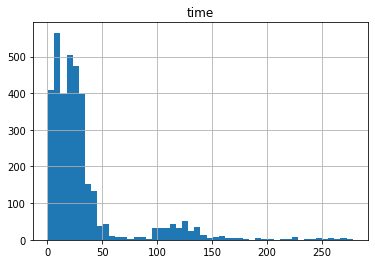

In [36]:
mean_schaetzer = track_data_train['time'].mean()
median_schaetzer = track_data_train['time'].median()
mode_schaetzer = float(track_data_train['time'].mode())
track_data_train.hist(column='time', bins=50)

print(mean_schaetzer)
print(median_schaetzer)
print(mode_schaetzer)

Define easy to interpret metrics: 

*   Percentage of prediction accurate within a week
*   Percentage of prediction accurate within a day



In [37]:
print("accurate within a week?")
print("mean_schaetzer" , sum((abs(track_data_test['time'] - mean_schaetzer))<=7)/len(track_data_test['time']))
print("median_schatzer", sum((abs(track_data_test['time'] - median_schaetzer))<=7)/len(track_data_test['time']))
print("mode_schaetzer", sum((abs(track_data_test['time'] - mode_schaetzer))<=7)/len(track_data_test['time']))
print( "accurate within a day?")
print("mean_schaetzer", sum((abs(track_data_test['time'] - mean_schaetzer))<=1)/len(track_data_test['time']))
print("median_schatzer", sum((abs(track_data_test['time'] - median_schaetzer))<=1)/len(track_data_test['time']))
print("mode_schaetzer", sum((abs(track_data_test['time'] - mode_schaetzer))<=1)/len(track_data_test['time']))


accurate within a week?
mean_schaetzer 0.26360544217687076
median_schatzer 0.3460884353741497
mode_schaetzer 0.20068027210884354
accurate within a day?
mean_schaetzer 0.027210884353741496
median_schatzer 0.1360544217687075
mode_schaetzer 0.06972789115646258


#3.2 Bivariate

Most promising feature: Event Location 

In [38]:
#Based on EventLocation
def predict_time_from_loc(location, method):
  if method == 'mean':
    mean = track_data_train[track_data_train['EventLocation'] == location]['time'].mean()
    if mean!=mean:
      return track_data_train['time'].mean()
    else:
      return mean
  if method == 'median':
    median = track_data_train[track_data_train['EventLocation'] == location]['time'].median()
    if median!=median:
      return track_data_train['time'].median()
    else:
      return median 
  if method == 'mode':
    mode = track_data_train[track_data_train['EventLocation'] == location]['time'].mode()
    if len(mode)==0:
      return float(track_data_train['time'].mode())
    try:
      return float(track_data_train['time'].mode())
    except:
      return mode

In [39]:
prediction_dict_mean = {}
prediction_dict_median = {}
prediction_dict_mode = {}
for location in list(name_to_GPS.keys()):
  prediction_dict_mean[location] = predict_time_from_loc(location,'mean')
  prediction_dict_median[location] = predict_time_from_loc(location,'median')
  prediction_dict_mode[location] = predict_time_from_loc(location,'mode')

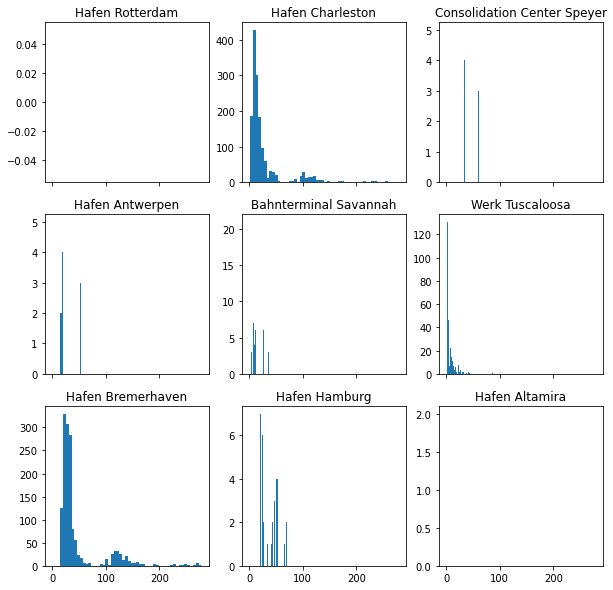

In [40]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex=True, figsize=(10,10))
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for n in range(len(axs)):
    location = list(name_to_GPS.keys())[n]
    df = track_data_train[track_data_train['EventLocation'] == location]['time']
    axs[n].hist(df, bins=50)    
    axs[n].set_title(location)
plt.show()

In [41]:
prediction_dict_mean

{'Hafen Rotterdam': 33.375459428894544,
 'Hafen Charleston': 27.650666666666666,
 'Consolidation Center Speyer': 35.89473684210526,
 'Hafen Antwerpen': 25.379310344827587,
 'Bahnterminal Savannah': 15.615384615384615,
 'Werk Tuscaloosa': 6.642651296829971,
 'Hafen Bremerhaven': 46.76766304347826,
 'Hafen Hamburg': 40.888888888888886,
 'Hafen Altamira': 127.0,
 'Hafen Aguascalientes': 126.0}

In [42]:
print("accurate within a week?")
print("mean_schaetzer" , sum(abs(track_data_test['time']-track_data_test.replace({"EventLocation" : prediction_dict_mean})['EventLocation'])<=7)/len(track_data_test['time']))
print("median_schaetzer" , sum(abs(track_data_test['time']-track_data_test.replace({"EventLocation" : prediction_dict_median})['EventLocation'])<=7)/len(track_data_test['time']))
print("mode_schaetzer" , sum(abs(track_data_test['time']-track_data_test.replace({"EventLocation" : prediction_dict_mode})['EventLocation'])<=7)/len(track_data_test['time']))
print( "accurate within a day?")
print("mean_schaetzer" , sum(abs(track_data_test['time']-track_data_test.replace({"EventLocation" : prediction_dict_mean})['EventLocation'])<=1)/len(track_data_test['time']))
print("median_schaetzer" , sum(abs(track_data_test['time']-track_data_test.replace({"EventLocation" : prediction_dict_median})['EventLocation'])<=1)/len(track_data_test['time']))
print("mode_schaetzer" , sum(abs(track_data_test['time']-track_data_test.replace({"EventLocation" : prediction_dict_mode})['EventLocation'])<=1)/len(track_data_test['time']))

accurate within a week?
mean_schaetzer 0.4651360544217687
median_schaetzer 0.3937074829931973
mode_schaetzer 0.20068027210884354
accurate within a day?
mean_schaetzer 0.047619047619047616
median_schaetzer 0.06717687074829932
mode_schaetzer 0.06972789115646258


#3.3 Multivariate Models

**Prepare datasets for multivariate Analysis**

Separate features and labels

In [43]:
X_train = track_data_train.drop(columns=['time'])
y_train = track_data_train['time']
X_test = track_data_test.drop(columns=['time'])
y_test = track_data_test['time']

Differentiate between different types of variables, introduce new features

In [44]:
all_cols = ['Container', 'ShipmentNumber', 'PoCreationDate', 'Material', 'Quant', 'EventName', 'EventTime', 'EventMessageTime', 'EventLocation', 'VesselName', 'PortofDischarge']
cat_cols = ['EventName', 'Material','EventLocation', 'VesselName', 'PortofDischarge']
ord_cols = ['PoCreationDate', 'EventTime']
real_cols = ['Quant']
leave_out = ['Container', 'ShipmentNumber', 'EventMessageTime']

#date_replacement_dict = {}
#X_train['PoCreationDate'].unique()
#always midnight and everything 2018
cyclical = CyclicalFeatures(variables=['PoCreationDatemonth','PoCreationDateday','EventTimemonth','EventTimeday','EventTimehour'], drop_original=False)

X_train['PoCreationDate'] = X_train['PoCreationDate'].apply(convert_to_strptime)
X_train['PoCreationDatemonth'] = X_train['PoCreationDate'].apply(lambda x: x.month)
X_train['PoCreationDateday'] = X_train['PoCreationDate'].apply(lambda x: x.day)
X_train.drop(columns=['PoCreationDate'],inplace=True)

X_train['EventTime'] = X_train['EventTime'].apply(convert_to_strptime)
X_train['EventTimemonth'] = X_train['EventTime'].apply(lambda x: x.month)
X_train['EventTimeday'] = X_train['EventTime'].apply(lambda x: x.day)
X_train['EventTimehour'] = X_train['EventTime'].apply(lambda x: x.hour)
X_train.drop(columns=['EventTime'],inplace=True)


X_train = cyclical.fit_transform(X_train)

X_test['PoCreationDate'] = X_test['PoCreationDate'].apply(convert_to_strptime)
X_test['PoCreationDatemonth'] = X_test['PoCreationDate'].apply(lambda x: x.month)
X_test['PoCreationDateday'] = X_test['PoCreationDate'].apply(lambda x: x.day)
X_test.drop(columns=['PoCreationDate'],inplace=True)

X_test['EventTime'] = X_test['EventTime'].apply(convert_to_strptime)
X_test['EventTimemonth'] = X_test['EventTime'].apply(lambda x: x.month)
X_test['EventTimeday'] = X_test['EventTime'].apply(lambda x: x.day)
X_test['EventTimehour'] = X_test['EventTime'].apply(lambda x: x.hour)
X_test.drop(columns=['EventTime'],inplace=True)

X_test = cyclical.fit_transform(X_test)


X_train = X_train.drop(columns=leave_out)
X_train = pd.get_dummies(X_train, columns=cat_cols)

X_test = X_test.drop(columns=leave_out)
X_test = pd.get_dummies(X_test, columns=cat_cols)


Some columns do not appear in the test set because there is no instance of it -> correct

In [45]:
train_cols = list(X_train.columns)
test_cols = list(X_test.columns)

for col in train_cols:
  if not col in test_cols:
    X_test[col] = 0

X_test = X_test.loc[:, train_cols]

Normalize the data

In [46]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**Try a GradientBoostingRegressor**

Train

In [47]:
model = GradientBoostingRegressor(learning_rate=0.1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [48]:
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: -12.547 (0.745)


Predict

In [49]:
model.fit(X_train, y_train)
yhat = model.predict(X_test)

In [50]:
print('First 10 Predictions:' , list(yhat)[:10])
print('First 10 GT: ', list(y_test)[:10])

Prediction: [40.02171071487789, 35.291946905357456, 46.376544916790664, 35.39754048906263, 30.66777667954215, 49.08311729664958, 36.76314070311668, 32.03337689359625, 50.44871751070364, 26.205640059250616, 21.475876249730177, 26.419173857743285, 26.519093182615766, 21.789329373095327, 26.73262698110844, 26.519093182615766, 21.789329373095327, 26.73262698110844, 5.233334217792384, 2.6610755151994656, 5.82028604982033, 36.22656862977325, 30.786278326919557, 30.786278326919557, 26.896899077835208, 20.79515516324239, 20.79515516324239, 2.6019560994246493, 36.22656862977325, 39.53836165165283, 30.786278326919557, 34.09807134879915, 30.786278326919557, 34.09807134879915, 26.896899077835208, 30.208692099714774, 20.79515516324239, 24.106948185121958, 20.79515516324239, 24.106948185121958, 12.594616760053702, 13.11736429230178, 35.86880011825504, 30.428509815401327, 30.428509815401327, 26.539130566316977, 20.43738665172416, 20.43738665172416, 4.40169269483394, 46.165025021911575, 40.72473471905

Percentage of predictions accurate within a week:

In [52]:
sum(abs(yhat-y_test)<=7)/len(y_test)

0.3826530612244898

**Try a simple Linear Regression**

In [53]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

-2.5927123909267364

Percentage of predictions accurate within a week:

In [ ]:
sum(abs(reg.predict(X_test)-y_test)<=7)/len(y_test)

Much more to do and try out such as PCA...

In [55]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_Scale = scaler.transform(X_train)
X_test_Scale = scaler.transform(X_test)

pca2 = PCA(n_components=2)
principalComponents = pca2.fit_transform(X_train_Scale)
print(principalComponents)

pca = PCA(n_components=2)
pca.fit(X_train)
PCA(n_components=2)
print(pca.explained_variance_ratio_)

print(pca.singular_values_)


[[ 4.33669717  3.73214844]
 [ 4.28715051  4.07241719]
 [ 4.3180929   4.20050414]
 ...
 [-0.64294256 -1.61966853]
 [-0.60877409 -1.02574121]
 [-0.5009316  -1.48355549]]
[0.07430693 0.05282629]
[126.61848749 106.75974051]


Open questions/things to do:


*   y_train auch normalisieren. Generell selber normalisieren
*   Group based on how the transport method is
*   New scheduling meaning? e.g. 5681685
*   Which time to predict precisely -> define properly?
*   Group shipments into single data point
*   Time2arrival depends on last package in shipment?
*   Missing/inconsistent data points, e.g. 4886163: arrival ship in charleston only appears once
*   Visualizations about percentages of routes taken
*   Develop on validation set
*   Which success metric?
*   Feature importance methods (PCA,..)
*   Time2Arrival imputen?














